## Learning GNs

What problems exist in the chain from the detector to the histogram of energies that I can think of rn:

* The integrated charge shape depends on the energy deposition profile in a complex way. 
* Pileup and backscattering exist and are difficult to detect, even on the same pixel/pulse - not to mention when they hit different pixels. 
* Recovering the energy and time is tough, and ensuring sufficient precision is even tougher
* There are weird things that can happen in the data, like cosmics, and it would be nice to filter them out.

Solutions:
* Tom's working on it, but I would like to later. It would be cool to throw in some other effects
* Ryan has a filtering method, I have some networks, ryan's working on getting GEANT simulations so we can optimize
* I have some filters and algorithms, but it needs a heck-ton of compute power
* clustering algorigthms identify them, but needs to be discussed before going further

Step 1 in GNs: build a GN to create parabolas with a given slope

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def genY(a, N, output_len):
    return np.ones(shape=(N,1))*a*np.arange(output_len)**2

In [6]:
def genX(N):
    return np.random.random(size=(N,1))

In [7]:
from keras.initializers import RandomNormal

Using TensorFlow backend.


In [8]:
from keras.layers import UpSampling1D

In [9]:
from keras.layers import LeakyReLU

In [10]:
from keras.models import Model
from keras.layers import Input, Dense

In [20]:
def generator(output_len, input_shape=(2,1)):
    X_in = Input(input_shape)
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    #X = UpSampling1D(size=int(output_len/input_shape[0]))(X_in)
    #X = LeakyReLU(alpha=0.2)(X)
    
    X = Dense(output_len, kernel_initializer=init)(X_in)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = Dense(output_len, kernel_initializer=init)(X)

    m = Model(inputs=X_in, outputs=X, name="GAN Prototype")
    m.compile(optimizer='adam', loss='mse')
    return m

In [21]:
g = generator(10, input_shape=(1,))

In [22]:
X = genX(1000)
y = genY(X, 1000, 10)

In [23]:
X.shape

(1000, 1)

In [24]:
y.shape

(1000, 10)

In [25]:
g.fit(X, y, epochs=200, verbose=False)

In [26]:
test = np.ones(shape=(1,1))

In [27]:
test

array([[1.]])

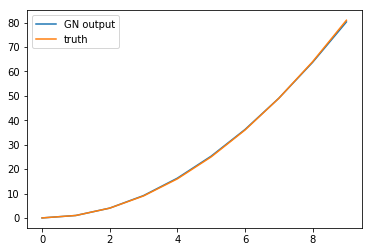

In [28]:
plt.plot(g.predict(test)[0], label='GN output')
plt.plot(genY(test, 1, 10)[0], label='truth')
plt.legend()

## Apply same thing to pileup generators

In [29]:
from numba import jit

In [30]:
@jit(nopython=True)
def makeNoPileup(amp, T0):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [31]:
wf = makeNoPileup(100,1000)

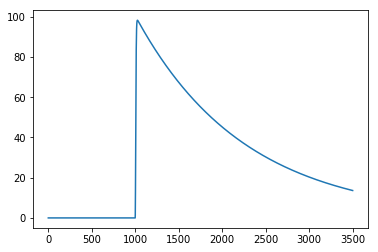

In [32]:
plt.plot(wf)

In [33]:
@jit(nopython=True)
def makePileup(amp, T0, delay, perc):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    amp1 = perc*amp
    ampTotal = amp
    T2 = T0+delay
    for i in range(length):
        
        if i>=T2:
            step[i%2]=1.
        elif i>=T0:
            step[i%2]=perc
        else:
            step[i%2]=0.

        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [34]:
wf = makePileup(100,1000,100,0.5)

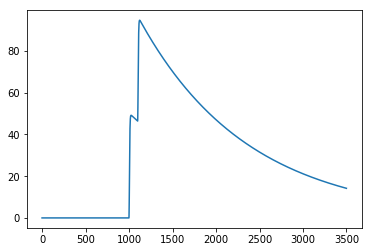

In [35]:
plt.plot(wf)

In [36]:
import numba

In [37]:
def genNoisyBatch(N):
    @jit(nopython=True, locals={'makePileup':numba.typeof(makePileup), 'makeNoPileup':numba.typeof(makeNoPileup)})
    
    def genNoNoise(N):
        data = np.empty((N,3500))
        E = np.random.randint(200,2000, size=N)
        T0= np.random.randint(900,1100, size=N)
        p = np.random.random(size=int(N/2))*0.8+0.1
        d = np.random.randint(30,400,size=int(N/2))

        for i in range(int(N/2)):
            data[i] = makeNoPileup(E[i],T0[i])
        for i in range((int(N/2)),N):
            data[i] = makePileup(E[i],T0[i],d[i-int(N/2)], p[i-int(N/2)])
        return data, T0, p, d
    
    compile_gen, _, _, _ = genNoNoise(1)
    
    data, T0, perc, delays = genNoNoise(N)
    
    delays = np.append(np.zeros(int(N/2)), delays)
    perc = np.append(np.zeros(int(N/2)), perc)
    
    
    noise = np.random.normal(scale=20., size=(N,3500))
    
    
    noisyData = data + noise
    
    @jit(nopython=True)
    def scale_it(N, noisyData):
        for i in range(N):
            noisyData[i] = noisyData[i]*2./np.amax(noisyData[i]) - 1.

    scale_it(1, data[:1])
    scale_it(N, noisyData)
    
    y = np.append(T0.reshape((N,1)), perc.reshape((N,1)), 1)
    y = np.append(y, delays.reshape((N,1)), 1)
    return noisyData, y

In [38]:
wf, y = genNoisyBatch(10)

In [39]:
y.shape

(10, 3)

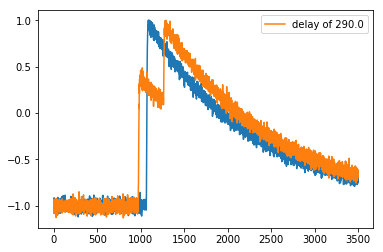

In [40]:
plt.plot(wf[0])
plt.plot(wf[-1], label='delay of '+str(y[-1][-1]))
plt.legend()

In [41]:
def shuffle(data, y):
    rnd_state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(rnd_state)
    np.random.shuffle(y)

In [62]:
def generator(output_len, input_shape=(2,1)):
    X_in = Input(input_shape)
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    X = Dense(int(output_len/16), kernel_initializer=init)(X_in)
    X = LeakyReLU(alpha=0.2)(X)
    
    X = UpSampling1D()(X)
    X = LeakyReLU(alpha=0.2)(X)    
 
    X = Dense(int(output_len/4), kernel_initializer=init)(X_in)
    X = LeakyReLU(alpha=0.2)(X)

    X = UpSampling1D()(X)
    X = LeakyReLU(alpha=0.2)(X)    
 
    #X = UpSampling1D()(X)
    #X = LeakyReLU(alpha=0.2)(X)    
 
    X = Dense(output_len, kernel_initializer=init)(X)

    m = Model(inputs=X_in, outputs=X, name="GAN Prototype")
    m.compile(optimizer='adam', loss='mse')
    return m

In [76]:
g = generator(700, input_shape=(3,))

In [77]:
X, y = genNoisyBatch(10000)
X = X[:,800:1500]
shuffle(X, y)

In [ ]:
g.fit(y, X, epochs=50, verbose=False)

In [ ]:
plt.plot(g.predict(np.array([1000,0.5,100]).reshape((1,3)))[0], label='GN output with T0 of 1000, perc: 0.5, delay of 100')
plt.legend()